# Reccomendation Model

## Importing Requirements

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from sklearn.metrics import classification_report
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from nltk.tokenize import RegexpTokenizer
import string
from PIL import Image
import requests
from io import BytesIO
from sklearn.preprocessing import MinMaxScaler

## EDA

In [189]:
df = pd.read_pickle('book.pkl','zip')

In [190]:
df.columns

Index(['title', 'authors', 'average_rating', 'isbn13', '  num_pages',
       'ratings_count', 'publication_date', 'publisher'],
      dtype='object')

### Exploring Most common books

In [191]:
most_occurent_books=df['title'].value_counts()[:15]


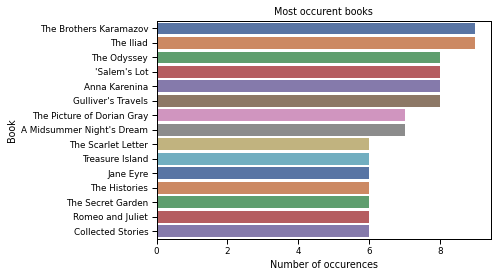

In [192]:
sns.barplot(x=most_occurent_books,y=most_occurent_books.index,palette='deep')
plt.title('Most occurent books')
plt.xlabel('Number of occurences')
plt.ylabel('Book')
plt.show()

### Exploring Most Common author

In [193]:
Freq_authors=df['authors'].value_counts()[:10]


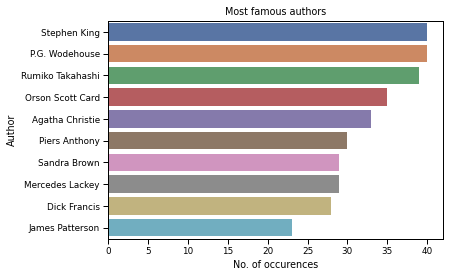

In [194]:
sns.barplot(x=Freq_authors,y=Freq_authors.index,palette='deep')
plt.title('Most famous authors')
plt.xlabel('No. of occurences')
plt.ylabel('Author')
plt.show()

### checking for correlation between rows

<AxesSubplot:>

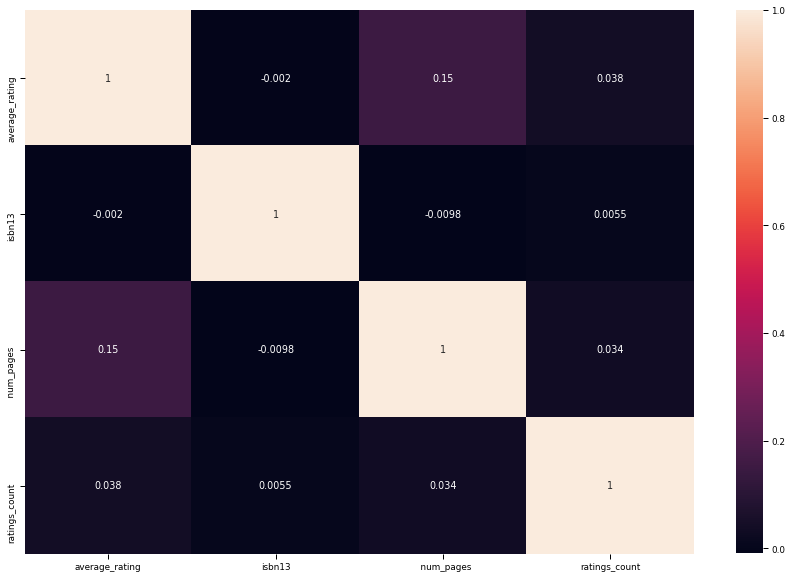

In [196]:
plt.figure(figsize=(15,10))

corr=df.corr()
sns.heatmap(corr,annot=True)

### Checking for distribution for average ratings

<AxesSubplot:xlabel='average_rating', ylabel='Count'>

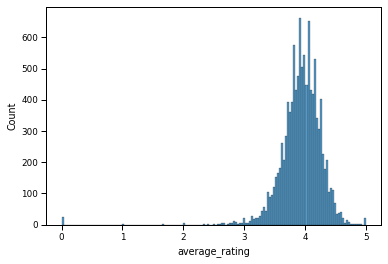

In [197]:
sns.histplot(df['average_rating'])


In [198]:
df_ratings=df[['title','authors','average_rating']]


In [199]:
demo=df_ratings.sort_values('average_rating',ascending=False).set_index('title')


In [200]:
demo1=df_ratings.sort_values('average_rating',ascending=False).set_index('authors')


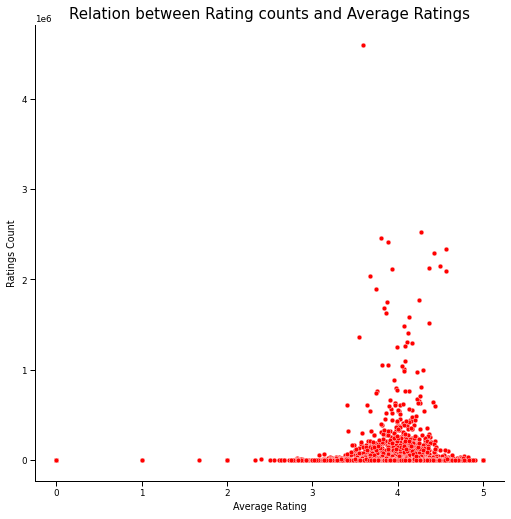

In [201]:
ax = sns.relplot(data=df, x="average_rating", y="ratings_count", color = 'red', sizes=(100, 200), height=7, marker='o')
plt.title("Relation between Rating counts and Average Ratings",fontsize = 15)
ax.set_axis_labels("Average Rating", "Ratings Count")

In [202]:
df2 = df.copy()

## Modeling

### changing the average ratings from continous to catagorical

In [203]:
df2.loc[ (df2['average_rating'] >= 0) & (df2['average_rating'] <= 1), 'rating_between'] = "between 0 and 1"
df2.loc[ (df2['average_rating'] > 1) & (df2['average_rating'] <= 2), 'rating_between'] = "between 1 and 2"
df2.loc[ (df2['average_rating'] > 2) & (df2['average_rating'] <= 3), 'rating_between'] = "between 2 and 3"
df2.loc[ (df2['average_rating'] > 3) & (df2['average_rating'] <= 4), 'rating_between'] = "between 3 and 4"
df2.loc[ (df2['average_rating'] > 4) & (df2['average_rating'] <= 5), 'rating_between'] = "between 4 and 5"

In [2]:
#df2.head()

### getting dummy variables for ratings

In [205]:
rating_df = pd.get_dummies(df2['rating_between'])
rating_df.head()

,between 0 and 1,between 1 and 2,between 2 and 3,between 3 and 4,between 4 and 5
bookID,,,,,
1,0,0,0,0,1
2,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
8,0,0,0,0,1


In [206]:
rating_df.tail()

,between 0 and 1,between 1 and 2,between 2 and 3,between 3 and 4,between 4 and 5
bookID,,,,,
45631,0,0,0,0,1
45633,0,0,0,0,1
45634,0,0,0,1,0
45639,0,0,0,1,0
45641,0,0,0,1,0


### Combining the dataframes

In [207]:
features = pd.concat([rating_df, df2['average_rating'], df2['ratings_count']], axis=1)
features.head()

,between 0 and 1,between 1 and 2,between 2 and 3,between 3 and 4,between 4 and 5,average_rating,ratings_count
bookID,,,,,,,
1,0,0,0,0,1,4.57,2095690
2,0,0,0,0,1,4.49,2153167
4,0,0,0,0,1,4.42,6333
5,0,0,0,0,1,4.56,2339585
8,0,0,0,0,1,4.78,41428


In [208]:
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

In [209]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(features)
idlist = model.kneighbors(features)

### Creating the function

In [223]:
def BookRecommender(book_name):
    book_list_name = []
    book_id = df2[df2['title'] == book_name].index
    book_id = book_id[0]
    for newid in idlist[book_id]:
        book_list_name.append(df2.iloc[newid].title)
    return book_list_name[:1]

## Final Result

In [224]:
BookNames = BookRecommender('Harry Potter and the Half-Blood Prince (Harry Potter  #6)')
BookNames

[bookID
 1        Harry Potter and the Half-Blood Prince (Harry ...
 2        Harry Potter and the Order of the Phoenix (Har...
 34       The Fellowship of the Ring (The Lord of the Ri...
 15881    Harry Potter and the Chamber of Secrets (Harry...
 5        Harry Potter and the Prisoner of Azkaban (Harr...
 28187    The Lightning Thief (Percy Jackson and the Oly...
 Name: title, dtype: object]